In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [24]:
import sys
sys.path.append('/home/tom/coding/ExTRA/')
import ExTRApack as ex

In [25]:
P=400
e=0.3
om=np.radians(0)
i=np.radians(30)
Om=np.radians(75)
J1991=2448349.0 #1991.25
J2000=2451545.0
J2016=2457389.0
T0=J1991+900
a=4

orbpar=np.array([P,e,om,i,Om,T0,a])

asc=20
dec=-10
parallax=200
mu_a_star=-100
mu_d=+300

gaia_standard=np.array([asc,dec,parallax,mu_a_star,mu_d])





v=10

t_test=np.linspace(T0-400,T0+400,1000)

model=ex.orbit(*orbpar,t_test)

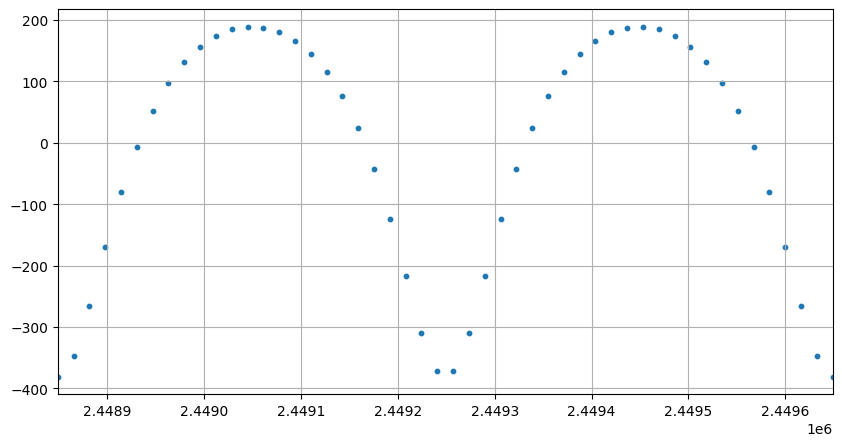

In [26]:
#rv
t_RV=np.concatenate([np.linspace(T0-430,T0-410,25),np.linspace(T0-400,T0,40),np.linspace(T0+80,T0+120,10)])

#t_RV=np.concatenate([np.linspace(T0-130,T0-50,25),np.linspace(T0,T0+30,10)])
t_RV=np.linspace(T0-400,T0+400,50)
RV=ex.RV_comb(v,P,e,om,i,T0,a,parallax,t_RV)
RV_err=np.ones(len(RV))*20

plt.figure(figsize=(10,5))
plt.scatter(t_RV,RV,s=10)
plt.xlim([t_RV[0],t_RV[-1]])
plt.grid()
plt.show()


In [27]:
#HIP
t_HIP=t_RV

earth=ex.earth_position(t_HIP)

std=np.array(ex.standard_model(asc,dec,parallax,mu_a_star,mu_d,t_HIP,earth,tangential=True))
orb=np.array(ex.orbit(P,e,om,i,Om,T0,a,t_HIP))
orb_mock=np.array(ex.orbit(P,e,om,i,Om-1.5,T0,a,t_HIP))
motion=std+orb



1.3089969389957472

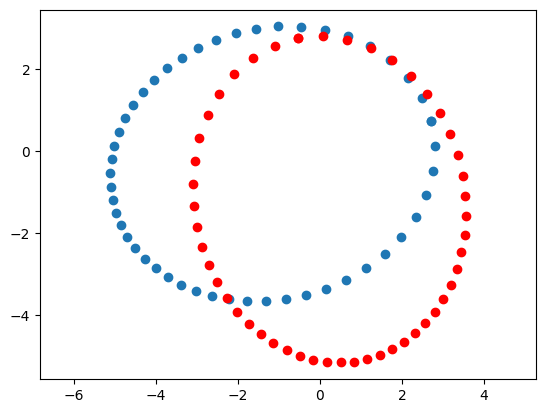

In [28]:
plt.scatter(*orb)
plt.scatter(*orb_mock,c="r")
plt.axis("equal")
Om

motion=std+orb
plt.scatter(motion[0],motion[1])
plt.show()

In [69]:
#A3,A4,A5,A6,A7,A8,A9=hip_ad


angle=np.arctan2(orb[1],orb[0])

A8=np.sqrt(orb[0]**2 + orb[1]**2)
A9=abs(np.random.normal(np.std(A8),0.5*np.std(A8),len(A8)))

#A9=np.ones(len(A8))*np.std(A8)*0.25

A5=np.zeros(len(A8))

#X and Y

A3=1*np.cos(angle)
A4=1*np.sin(angle)

#year of mesaurement after J2000
epoch=(t_HIP-J2000)/365.25 +2000

#years after HIP stand epoch
frac=epoch-1991.25
A6=frac*A3
A7=frac*A4 #to A4 corresponding poper motion factor


HIP=A3,A4,A5,A6,A7,A8,A9

hip_standard=np.zeros(5)


hip_standard[0],hip_standard[1]=ex.pos_recalc(*gaia_standard[:4],J2016,J1991)


hip_standard[3:5]=np.array(gaia_standard[3:5])#+np.random.normal(0,2,1)
#solar aspect angle 43 deg



In [57]:
A5

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

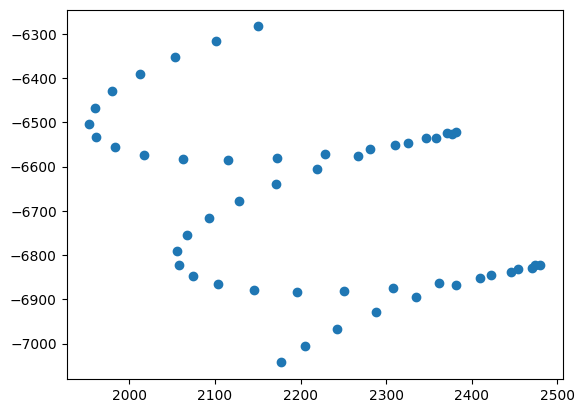

In [58]:
plt.scatter(*motion)
earth_test=ex.earth_position(t_test)
model_stand=(ex.standard_model(asc,dec,parallax,mu_a_star,mu_d,t_test,earth_test,tangential=1))
#plt.plot(*model_stand,c="r",linestyle="--")
plt.show()

(-6.747382761714526, 5.045990648821011, -6.767226217573909, 4.554609177019004)

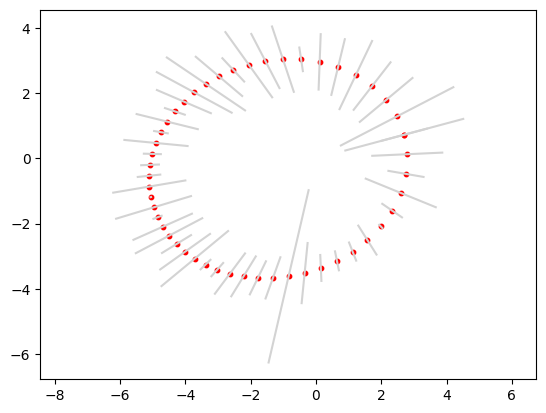

In [59]:
testing=ex.hip_2d(HIP[0],HIP[1],HIP[-2],HIP[-1])


ex.plot_real(*testing,s=10)
plt.axis("equal")

In [60]:


gaia_error=np.zeros(5)

gaia_error[0]=10#mas
gaia_error[1]=-5#mas
gaia_error[3]=7
gaia_error[4]=8
###the fit will return-1*gaia_error as the correction

gaia_wrong=ex.stand_correct(gaia_standard,gaia_error)

hipdata=[hip_standard,HIP,gaia_wrong]

In [61]:
hipdata[2]

array([ 20.00000278, -10.00000139, 200.        , -93.        ,
       308.        ])

In [62]:
def fitting_hip(pars,data):

    
    corr=pars[:5]
    orbpar=pars[5:]

    hip_standard=data[0]
    HIP=data[1]
    gaia=data[2]

    
    

    

    L=ex.L_hip(HIP,hip_standard,gaia,corr,*orbpar)
    #print(L)
    
    return L

In [63]:

orbguess=np.array([P+10,e+0.5,om+0.5,i+np.pi,Om-1.5,T0,a+2])
#orbguess=orbpar
x0=np.concatenate((-1*gaia_error,orbguess))

stand_const=(-10,10),(-10,10),(0,0),(-20,20),(-20,20)
#stand_const=(0,0),(0,0),(0,0),(0,0),(0,0)
orb_const=(P-100,P+100),(0.1,0.9),(-1*np.pi,+1*np.pi),(0,2*np.pi),(-1*np.pi,+1*np.pi),(T0-2*P,T0+2*P),(1,10)
bnds=stand_const+orb_const

In [64]:
final=minimize(fitting_hip,x0,hipdata,bounds=bnds,method="L-BFGS-B",options={"ftol":1e-5})

    



In [65]:
final.x[5:]-orbpar

array([10.81705763, -0.0449538 , -1.82874766,  5.75958653, -4.22040121,
       10.82696773, -0.25455698])

In [66]:
final.fun-fitting_hip(np.concatenate([-1*gaia_error,orbpar]),hipdata)

4.013472658898532

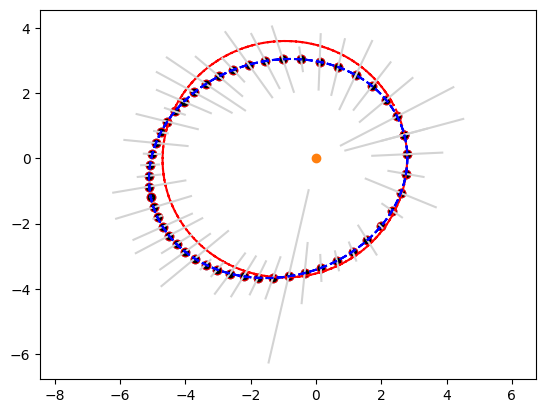

In [67]:


plt.scatter(*ex.orbit(*orbpar,t_HIP))
plt.plot(*ex.orbit(*final.x[5:],t_test),linestyle="--",color="r")
plt.scatter(*orb,color="r")
ex.plot_real(*testing,s=20,co="k")
plt.plot(*model,color="b",linestyle="--")
plt.scatter(0,0)
plt.axis("equal")
plt.show()

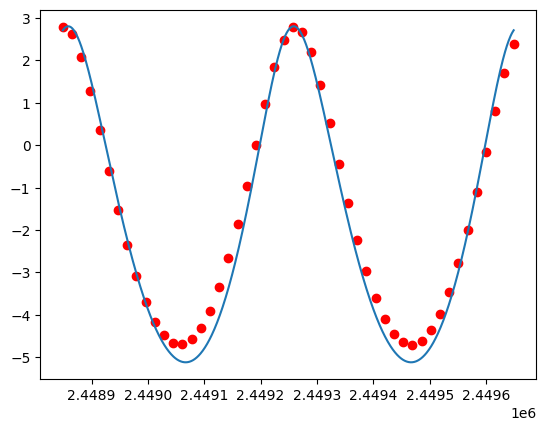

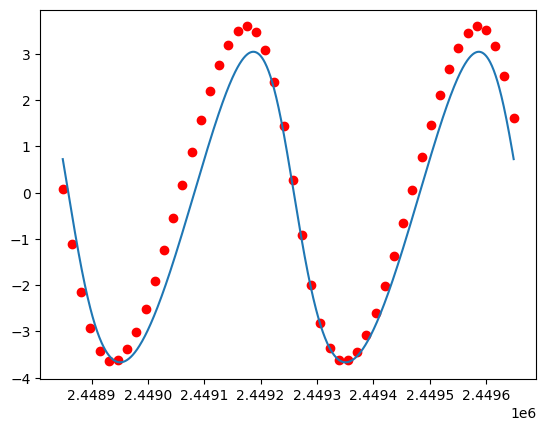

In [68]:
plt.plot(t_test,model[0])
#plt.plot(t_test,ex.orbit(*final.x[5:],t_test)[0])
plt.scatter(t_RV,ex.orbit(*final.x[5:],t_RV)[0],c="r")

plt.show()

plt.plot(t_test,model[1])
#plt.plot(t_test,ex.orbit(*final.x[5:],t_test)[1])
plt.scatter(t_RV,ex.orbit(*final.x[5:],t_RV)[1],c="r")
plt.show()

In [42]:
data=RV,RV_err,t_RV,HIP,hip_standard,gaia_wrong

In [43]:
def fitting(pars,*data):

    
    
    corr=pars[:5]
    orbpar=pars[5:12]
    v=pars[12:]
    
    print(pars)
    L=ex.L_combined(*data,v,corr,*orbpar)


    return L



In [44]:
orbguess

array([ 4.10000000e+02,  8.00000000e-01,  5.00000000e-01,  3.66519143e+00,
       -1.91003061e-01,  2.44924900e+06,  6.00000000e+00])

In [45]:
diff=np.zeros(5)
diff=-1*gaia_error
x0_comb=np.concatenate((diff,orbguess,np.array([v])))

stand_const=(-10,10),(-10,10),(0,0),(-20,20),(-20,20)

orb_const=(P-100,P+100),(0,0.9),(-1*np.pi,+1*np.pi),(0*np.pi,2*np.pi),(-1*np.pi,+1*np.pi),(T0-2*P,T0+2*P),(0,10)
v_bnds=(-20,20),


bnds=stand_const+orb_const+v_bnds

In [46]:
final_comb=minimize(fitting,x0_comb,data,bounds=bnds,options={"ftol":1e-10})

[-1.00000000e+01  5.00000000e+00  0.00000000e+00 -7.00000000e+00
 -8.00000000e+00  4.10000000e+02  8.00000000e-01  5.00000000e-01
  3.66519143e+00 -1.91003061e-01  2.44924900e+06  6.00000000e+00
  1.00000000e+01]
[-9.99999999e+00  5.00000000e+00  0.00000000e+00 -7.00000000e+00
 -8.00000000e+00  4.10000000e+02  8.00000000e-01  5.00000000e-01
  3.66519143e+00 -1.91003061e-01  2.44924900e+06  6.00000000e+00
  1.00000000e+01]
[-1.00000000e+01  5.00000001e+00  0.00000000e+00 -7.00000000e+00
 -8.00000000e+00  4.10000000e+02  8.00000000e-01  5.00000000e-01
  3.66519143e+00 -1.91003061e-01  2.44924900e+06  6.00000000e+00
  1.00000000e+01]
[-1.00000000e+01  5.00000000e+00  0.00000000e+00 -6.99999999e+00
 -8.00000000e+00  4.10000000e+02  8.00000000e-01  5.00000000e-01
  3.66519143e+00 -1.91003061e-01  2.44924900e+06  6.00000000e+00
  1.00000000e+01]
[-1.00000000e+01  5.00000000e+00  0.00000000e+00 -7.00000000e+00
 -7.99999999e+00  4.10000000e+02  8.00000000e-01  5.00000000e-01
  3.66519143e+00 -

In [47]:
i

0.5235987755982988

In [48]:
final_comb.x

array([-1.00000000e+01,  4.90105613e+00,  0.00000000e+00,  2.00000000e+01,
       -2.00000000e+01,  3.00000000e+02,  7.55182286e-01,  1.59312739e+00,
        0.00000000e+00, -1.83171101e+00,  2.44947165e+06,  1.00000000e+01,
        9.70604947e+00])

In [49]:
final_comb.x[5:-1]-orbpar

array([-100.        ,    0.45518229,    1.59312739,   -0.52359878,
         -3.14070794,  222.64956083,    6.        ])

In [50]:
final_comb.x[8]

0.0

In [51]:
final_comb.fun

1841680.7404376138

In [52]:
K1=2*np.pi*a*np.sin(i)*1.495978707e11/(parallax)
K2=(P*86400*(1-e**2)**0.5)
K=K1/K2

In [53]:
final_comb.fun-fitting(np.concatenate([-1*gaia_error,orbpar,np.array([v])]),*data)

[-1.00000000e+01  5.00000000e+00 -0.00000000e+00 -7.00000000e+00
 -8.00000000e+00  4.00000000e+02  3.00000000e-01  0.00000000e+00
  5.23598776e-01  1.30899694e+00  2.44924900e+06  4.00000000e+00
  1.00000000e+01]


-5542342.527970354

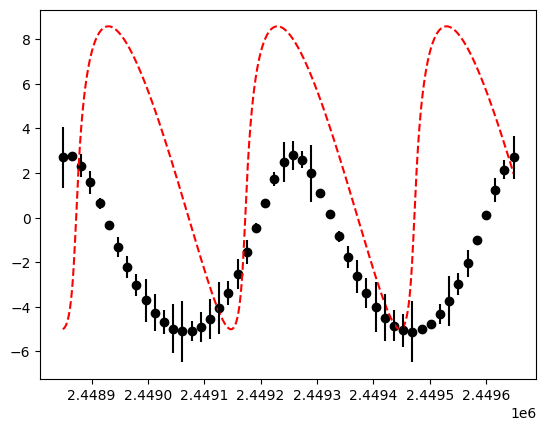

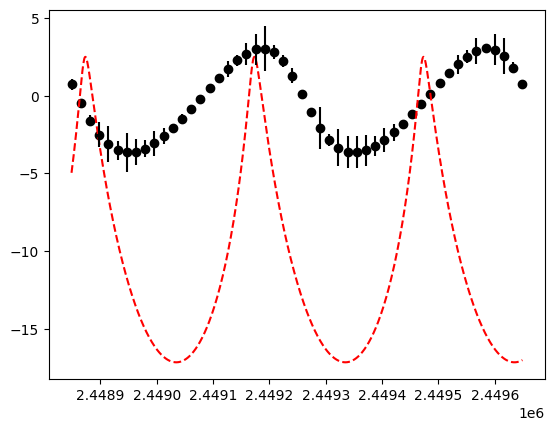

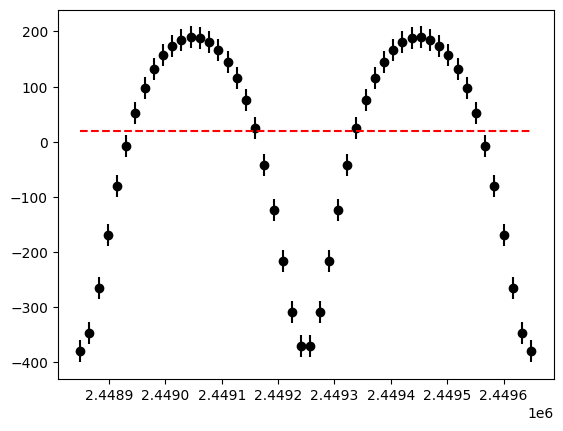

In [54]:
fit=ex.orbit(*final_comb.x[5:12],t_test)
kek=ex.hip_2d(A3,A4,A8,A9)

plt.plot(t_test,fit[0],color="r",linestyle="--")
#plt.plot(t_test,model[0])
plt.scatter(t_HIP,orb[0],color="k")
plt.errorbar(t_HIP,kek[0],abs(kek[1]),linestyle=" ",color="k")

plt.show()


plt.plot(t_test,fit[1],color="r",linestyle="--")
#plt.plot(t_test,model[1])
plt.scatter(t_HIP,orb[1],color="k")
plt.errorbar(t_HIP,kek[2],abs(kek[3]),linestyle=" ",color="k")

plt.show()

plt.scatter(t_RV,RV,color="k")
plt.errorbar(t_RV,RV,RV_err,color="k",linestyle=" ")
plt.plot(t_test,ex.RV_comb(*final_comb.x[4:9],final_comb.x[10],final_comb.x[11],parallax,t_test),linestyle="--",color="r")

plt.show()


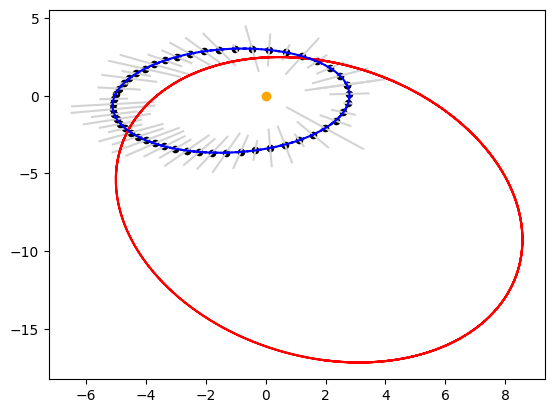

In [55]:


ex.plot_real(*testing,s=20,co="k")

plt.plot(*fit,color="r")

plt.plot(*model,color="b",linestyle="--")
plt.scatter(0,0,c="orange")
plt.show()

